In [2]:
from fastai import *
from fastai.tabular import *
from fastai.text import *

In [3]:
%matplotlib inline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from collections import Counter
import random

In [4]:
#use this cell when working online
path = '/floyd/home/ed-triage'
data_path = '/floyd/home/data/combined'
model_path = 'floyd/home/models'

In [ ]:
#use this cell in google colab
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = '/content/drive/My Drive/ML_data'
data = pd.read_csv('/content/drive/My Drive/ML_data/complete_clean_combo_data.csv', index_col = 0,low_memory = False)

In [13]:
data = pd.read_csv(data_path + '/complete_clean_combo_data.csv', index_col = 0,low_memory = False)

In [14]:
data = data[['CleanSubjectiveNotes','CleanMedicalHistory', 'outcome', 'target', 'service', 'target2',
       'discharge', 'target3', 'dispo', 'target4', 'ICUvsother', 'target5']]

In [6]:
data.columns, data.shape

(Index(['CleanSubjectiveNotes', 'CleanMedicalHistory', 'outcome', 'target',
        'service', 'target2', 'discharge', 'target3', 'dispo', 'target4',
        'ICUvsother', 'target5'],
       dtype='object'), (165957, 12))

In [7]:
data.head()

,CleanSubjectiveNotes,CleanMedicalHistory,outcome,target,service,target2,discharge,target3,dispo,target4,ICUvsother,target5
511,complains of central chest tightness since yes...,childhood heart murmur drug abuse,discharge,1.0,discharge,1.0,discharge,1.0,NaN,NaN,NaN,0.0
754,patient says noted blood in stool yesterday an...,seizure,discharge,1.0,discharge,1.0,discharge,1.0,NaN,NaN,NaN,0.0
755,"right flank pain since morning,on her periods ...",no significant medical history ovarian cyst,discharge,1.0,discharge,1.0,discharge,1.0,NaN,NaN,NaN,0.0
757,"abdo pain onset monday,not seen by family doctor",no significant medical history,discharge,1.0,discharge,1.0,discharge,1.0,NaN,NaN,NaN,0.0
758,"fell last monday landed on ground, "" dizzy"" at...","high cholesterol, 2 stents 2014,low bp",discharge,1.0,discharge,1.0,discharge,1.0,NaN,NaN,NaN,0.0


In [16]:
data.dropna(subset = ['CleanSubjectiveNotes','CleanMedicalHistory'], inplace = True)
data.shape

(165433, 12)

In [21]:
#language model databunch based on full dataset, subjective notes only
data_lm = (TextList.from_df(data, cols=['CleanSubjectiveNotes'])
                   .split_by_rand_pct(0.2)
                   .label_for_lm()
                   .databunch())

In [22]:
#classification databunch for full dataset and languange model
data_clas = (TextList.from_df(data, cols=['CleanSubjectiveNotes'],vocab=data_lm.vocab)
                   .split_by_rand_pct(0.2)
                   .label_from_df(cols = 'discharge')
                   .databunch())

In [23]:
data_lm.save('combo_subjnote_lmdb')
data_clas.save('combo_subjnote_2clsdb')

In [4]:
data_lm = load_data(path,'combo_subjnote_lmdb')
data_clas = load_data(path, 'combo_subjnote_2clsdb')

#adding a line to also do backwards languange model for later ensembling
data_lm_bwd = load_data(path, 'combo_subjnote_lmdb', backwards=True)
data_clas_bwd = load_data(path, 'combo_subjnote_2clsdb', backwards=True)

In [17]:
lmlearn = language_model_learner(data_lm, arch = AWD_LSTM, drop_mult=0.3)
lmlearn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))
lmlearn.unfreeze()
lmlearn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.511308,3.361519,0.337112,01:53
1,3.350716,3.226523,0.351019,01:51
2,3.254168,3.184404,0.356153,01:52


epoch,train_loss,valid_loss,accuracy,time
0,3.053620,3.013506,0.379458,02:13
1,2.961339,2.904429,0.395557,02:13
2,2.805523,2.796406,0.410472,02:13
3,2.616774,2.713645,0.422722,02:13
4,2.450129,2.708107,0.425021,02:13


In [6]:
#trying with mixed precision to see effect on speed
lmlearn = language_model_learner(data_lm, arch = AWD_LSTM, drop_mult=0.3)
lmlearn = lmlearn.to_fp16(clip = 0.1)
lmlearn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))
lmlearn.unfreeze()
lmlearn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.519304,3.358785,0.337543,01:39
1,3.345312,3.223199,0.351415,01:37
2,3.247420,3.181988,0.356722,01:37


epoch,train_loss,valid_loss,accuracy,time
0,3.042106,3.004239,0.381350,01:59
1,2.972202,2.906155,0.395981,01:59
2,2.812612,2.794336,0.411010,01:59
3,2.626635,2.713431,0.423369,01:59
4,2.458011,2.708002,0.425684,02:00


In [7]:
#the above training scheme is good so I'm going to save this as my language model
#which is basically saving the embedding matrix from the language modelling nerual network
lmlearn.save_encoder(path + '/edsent_v4_enc_fwd')

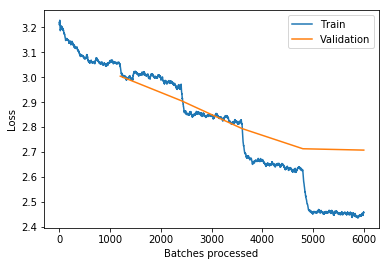

In [8]:
lmlearn.recorder.plot_losses()

In [9]:
lmlearn2 = language_model_learner(data_lm_bwd, arch = AWD_LSTM, drop_mult=0.3)
lmlearn2 = lmlearn2.to_fp16(clip = 0.1)
lmlearn2.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))
lmlearn2.unfreeze()
lmlearn2.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.720891,3.562228,0.333783,01:38
1,3.548327,3.387107,0.351350,01:38
2,3.428431,3.340900,0.356899,01:38


epoch,train_loss,valid_loss,accuracy,time
0,3.148320,3.093826,0.389397,02:01
1,3.020941,2.961259,0.408931,02:00
2,2.871433,2.846726,0.425896,02:00
3,2.676183,2.764557,0.438825,02:00
4,2.512920,2.756891,0.441208,02:00


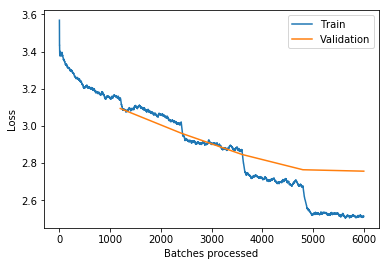

In [10]:
lmlearn2.recorder.plot_losses()

In [11]:
lmlearn2.save_encoder(path + '/edsent_v4_enc_bwd')

All that work was done to get the best language model I could get which seems to have accuracy of about 48%.  I made one forward language model and 1 backwards 1

Now on to training the classifier


In [24]:
f1 = FBeta(beta=1, average = 'weighted')
def train_triage_classifier(encoder_name, datac = data_clas, datal = data_lm, 
                            mets = [accuracy,f1], num_cycles = 1, lr = 1e-2, drop_mult = 0.5):
    model = text_classifier_learner(datac, metrics = mets, arch = AWD_LSTM, drop_mult=drop_mult)
    model = model.to_fp16(clip=0.1)
    model.load_encoder(path + '/' + encoder_name)
    model.fit_one_cycle(num_cycles, lr, moms=(0.8,0.7))
    model.freeze_to(-2)
    model.fit_one_cycle(num_cycles, slice(lr/(2.6**4),lr), moms=(0.8,0.7))
    model.freeze_to(-3)
    model.fit_one_cycle(num_cycles, slice((lr/2)/(2.6**4),(lr/2)), moms=(0.8,0.7))
    model.unfreeze()
    model.fit_one_cycle(num_cycles*5, slice((lr/100)/(2.6**4),(lr/100)), moms=(0.8,0.7))
    model.recorder.plot_losses()
    return model

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.259393,0.266615,0.902497,0.863880,01:10


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.275566,0.262841,0.903978,0.866117,01:19


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.275580,0.262032,0.904068,0.866122,01:59


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.286219,0.261927,0.904038,0.867065,02:47
1,0.251020,0.261475,0.904310,0.869359,02:42
2,0.267621,0.262013,0.903796,0.867437,02:49
3,0.256632,0.261471,0.903857,0.867939,02:46
4,0.259642,0.261296,0.904189,0.868418,02:45


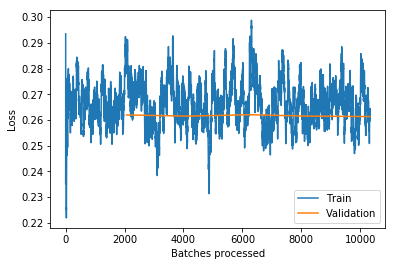

In [22]:
sent_learn = train_triage_classifier('edsent_v4_enc', datac = data_clas, num_cycles = 1, lr = 1e-3)

In [ ]:
preds, targets = sent_learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

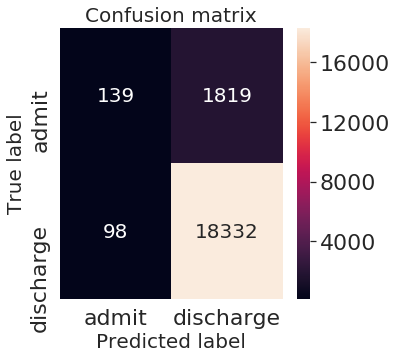

In [ ]:
sns.set(font_scale=2)

LABELS = data_clas.classes

confusion_matrix = metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [ ]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)

weighted f1:  0.8712105081031505
f1:           [0.126651 0.950312]
accuracy:     0.9059741024131842
precision:    [0.586498 0.909732]
recall:       [0.070991 0.994683]


In [23]:
sent_learn.save(path + '/models/edsentv4')

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.636196,0.641376,0.654234,0.723643,01:09


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.598904,0.584200,0.781297,0.812487,01:22


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,nan,nan,0.097896,0.017458,01:57


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,nan,nan,0.097896,0.017458,02:32
1,nan,nan,0.097896,0.017458,02:27
2,nan,nan,0.097896,0.017458,02:25
3,nan,nan,0.097896,0.017458,02:30
4,nan,nan,0.097896,0.017458,02:22


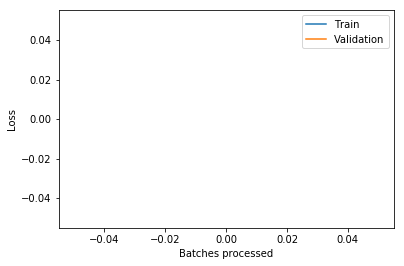

In [33]:
sent_learn_b = train_triage_classifier('edsent_v4_enc_bwd', datac = data_clas_bwd, num_cycles = 1, lr = 1e-5)

In [34]:
preds_b, targets_b = sent_learn_b.get_preds(DatasetType.Valid) 
predictions_b = np.argmax(preds_b, axis = 1) 

In [ ]:
sns.set(font_scale=2)

LABELS = data_clas_bwd.classes

confusion_matrix = metrics.confusion_matrix(targets_b, predictions_b)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [ ]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)

In [ ]:
sent_learn2.save(path + '/models/edsentv4_bwd')

In [ ]:
#ensembled

final_pred = (preds+preds_b)/2
final_predictions = np.argmax(final_pred, axis = 1) 

In [ ]:
f1_w = sklearn.metrics.f1_score(targets, final_predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, final_predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, final_predictions)
prec = sklearn.metrics.precision_score(targets,final_predictions, average = None)
rec = sklearn.metrics.recall_score(targets,final_predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)

In [ ]:
sns.set(font_scale=2)

LABELS = data_clas_bwd.classes

confusion_matrix = metrics.confusion_matrix(targets, final_predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

trying the training scheme for longer to see effect on model quality

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.277756,0.268729,0.902829,0.858972,01:09
1,0.265370,0.264945,0.903494,0.863294,01:08
2,0.283726,0.263435,0.903736,0.864547,01:07


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.276389,0.263135,0.903615,0.865073,01:17
1,0.283682,0.259857,0.904189,0.867298,01:20
2,0.260292,0.258930,0.904975,0.869680,01:16


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.250165,0.259150,0.904703,0.868314,02:02
1,0.269792,0.259158,0.904461,0.872242,02:07
2,0.255961,0.258339,0.904794,0.873659,02:02


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.254742,0.258284,0.905066,0.873383,02:41
1,0.260624,0.258372,0.905126,0.872415,02:42
2,0.240468,0.258286,0.905126,0.873876,02:43
3,0.232615,0.258247,0.905277,0.873479,02:37
4,0.249535,0.258147,0.904824,0.874647,02:43
5,0.257192,0.258166,0.905247,0.873790,02:41
6,0.239226,0.258095,0.904612,0.873744,02:45
7,0.249006,0.258520,0.904431,0.873949,02:40
8,0.254939,0.258617,0.905217,0.873064,02:42
9,0.257687,0.258116,0.904733,0.873783,02:37


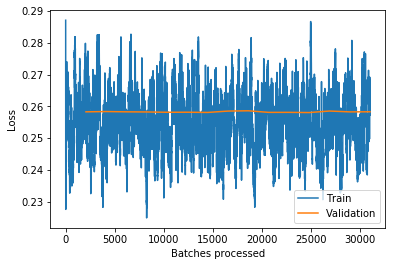

In [24]:
sent_learn = train_triage_classifier('edsent_v4_enc', datac = data_clas, num_cycles = 3, lr = 1e-3)

In [25]:
preds, targets = sent_learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

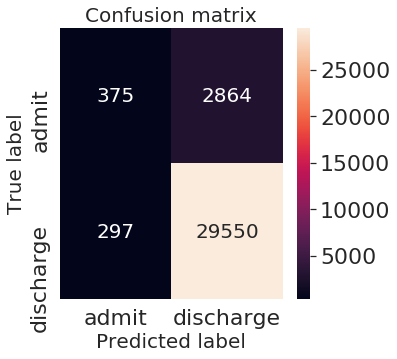

In [26]:
sns.set(font_scale=2)

LABELS = data_clas.classes

confusion_matrix = metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [31]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)

weighted f1:  0.8750769565310259
f1:           [0.191767 0.94923 ]
accuracy:     0.9044611013721816
precision:    [0.558036 0.911643]
recall:       [0.115776 0.990049]


In [38]:
sent_learn.save(path + '/models/edsentv4_v2')

#### the work above was all to create an nlp model for looking at the subjective notes.  now gonna do the same for the medical history and try to ensemble them

In [17]:
#language model databunch based on full dataset, subjective notes only
data_lm_2 = (TextList.from_df(data, cols=['CleanMedicalHistory'])
                   .split_by_rand_pct(0.2)
                   .label_for_lm()
                   .databunch())
data_lm_2.save('combo_medhx_lmdb')

In [18]:
#classification databunch for full dataset and languange model
data_clas_2 = (TextList.from_df(data, cols=['CleanMedicalHistory'],vocab=data_lm_2.vocab)
                   .split_by_rand_pct(0.2)
                   .label_from_df(cols = 'discharge')
                   .databunch())
data_clas_2.save('combo_medhx_2clsdb')

In [5]:
data_lm_2 = load_data(path,'combo_medhx_lmdb')
data_clas_2 = load_data(path, 'combo_medhx_2clsdb')

#adding a line to also do backwards languange model for later ensembling
data_lm_2_bwd = load_data(path, 'combo_medhx_lmdb', backwards=True)

In [6]:
lmlearn3 = language_model_learner(data_lm_2, arch = AWD_LSTM, drop_mult=0.3)
lmlearn3 = lmlearn3.to_fp16(clip=0.1)
lmlearn3.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))
lmlearn3.unfreeze()
lmlearn3.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.098043,1.641210,0.704339,01:33
1,1.639379,1.572317,0.709612,01:34
2,1.590445,1.560422,0.710854,01:34


epoch,train_loss,valid_loss,accuracy,time
0,1.576757,1.552725,0.707245,02:03
1,1.556235,1.523468,0.712361,02:03
2,1.495239,1.497305,0.716104,02:02
3,1.424025,1.488241,0.717374,02:03
4,1.330946,1.501519,0.716453,02:02


In [7]:
lmlearn3.save_encoder(path + '/edsent_v4medhx_enc_fwd')

In [8]:
lmlearn4 = language_model_learner(data_lm_2_bwd, arch = AWD_LSTM, drop_mult=0.3)
lmlearn4 = lmlearn4.to_fp16(clip=0.1)
lmlearn4.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))
lmlearn4.unfreeze()
lmlearn4.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.283215,1.679885,0.686147,01:34
1,1.668851,1.586794,0.692588,01:34
2,1.611559,1.573284,0.694806,01:34


epoch,train_loss,valid_loss,accuracy,time
0,1.578810,1.547934,0.696717,02:03
1,1.559473,1.520959,0.698024,02:03
2,1.498080,1.501309,0.700953,02:02
3,1.422155,1.491076,0.702200,02:02
4,1.332075,1.505634,0.702372,02:02


In [9]:
lmlearn4.save_encoder(path + '/edsent_v4medhx_enc_bwd')

In [43]:
sent_learn = train_triage_classifier('edsent_v4medhx_enc', datac = data_clas_2, datal = data_lm_2, num_cycles = 1, lr = 1e-3)

RuntimeError: Error(s) in loading state_dict for AWD_LSTM:
	size mismatch for encoder.weight: copying a param with shape torch.Size([2886, 400]) from checkpoint, the shape in current model is torch.Size([16378, 400]).
	size mismatch for encoder_dp.emb.weight: copying a param with shape torch.Size([2886, 400]) from checkpoint, the shape in current model is torch.Size([16378, 400]).